In [15]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
seg_length = 200

routing_file = open('.routing', 'r')
Lines = routing_file.readlines()

# List of parsed logfiles
keyboard = []
mouse = []

for line in Lines:
    line = line.strip()
    if 'keyboard_actions.log' in line:
        keyboard.append(parse_keyboard_log(line))
    elif 'mouse_actions.log' in line:
        mouse.append(parse_mouse_log(line))

# Split into train and test sets
X_train = []
X_test = []
Y_train = []
Y_test = []

for k in range(len(keyboard) - 1):
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        heatmap = heatmap.to_binary_class_label("JONSPY")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_train.append(heatmap.heatmap_data().ravel().tolist())
            Y_train.append(heatmap.class_label())

for k in range(len(keyboard) - 1,len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        heatmap = heatmap.to_binary_class_label("JONSPY")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_test.append(heatmap.heatmap_data().ravel().tolist())
            Y_test.append(heatmap.class_label())

print(f"Train samples: {len(Y_train)}")
print(f"Test samples: {len(Y_test)}")

Train samples: 54
Test samples: 36


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( f"Train score: {rfc.score(X_train, Y_train)} " + f"Test score: {rfc.score(X_test, Y_test)}")

Train score: 1.0 Test score: 0.19444444444444445


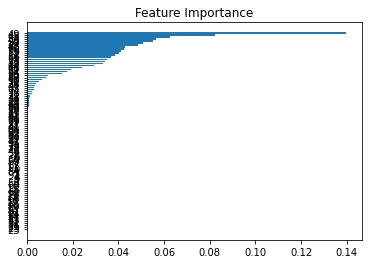

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# names = [magicFunctionThatGivesNames() for i in indices]

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), [indices[i] for i in indices])
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(344.44444444444446, 543.6, 'X[11] <= 0.289\ngini = 0.384\nsamples = 34\nvalue = [40, 14]'),
 Text(206.66666666666666, 422.8, 'X[0] <= 0.138\ngini = 0.206\nsamples = 25\nvalue = [38, 5]'),
 Text(137.77777777777777, 302.0, 'X[8] <= 0.393\ngini = 0.469\nsamples = 6\nvalue = [3, 5]'),
 Text(68.88888888888889, 181.2, 'gini = 0.0\nsamples = 2\nvalue = [3, 0]'),
 Text(206.66666666666666, 181.2, 'gini = 0.0\nsamples = 4\nvalue = [0, 5]'),
 Text(275.55555555555554, 302.0, 'gini = 0.0\nsamples = 19\nvalue = [35, 0]'),
 Text(482.2222222222222, 422.8, 'X[58] <= 0.035\ngini = 0.298\nsamples = 9\nvalue = [2, 9]'),
 Text(413.3333333333333, 302.0, 'X[64] <= 0.07\ngini = 0.18\nsamples = 8\nvalue = [1, 9]'),
 Text(344.44444444444446, 181.2, 'X[61] <= 0.01\ngini = 0.219\nsamples = 7\nvalue = [1, 7]'),
 Text(275.55555555555554, 60.39999999999998, 'gini = 0.0\nsamples = 6\nvalue = [0, 7]'),
 Text(413.3333333333333, 60.39999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(482.2222222222222

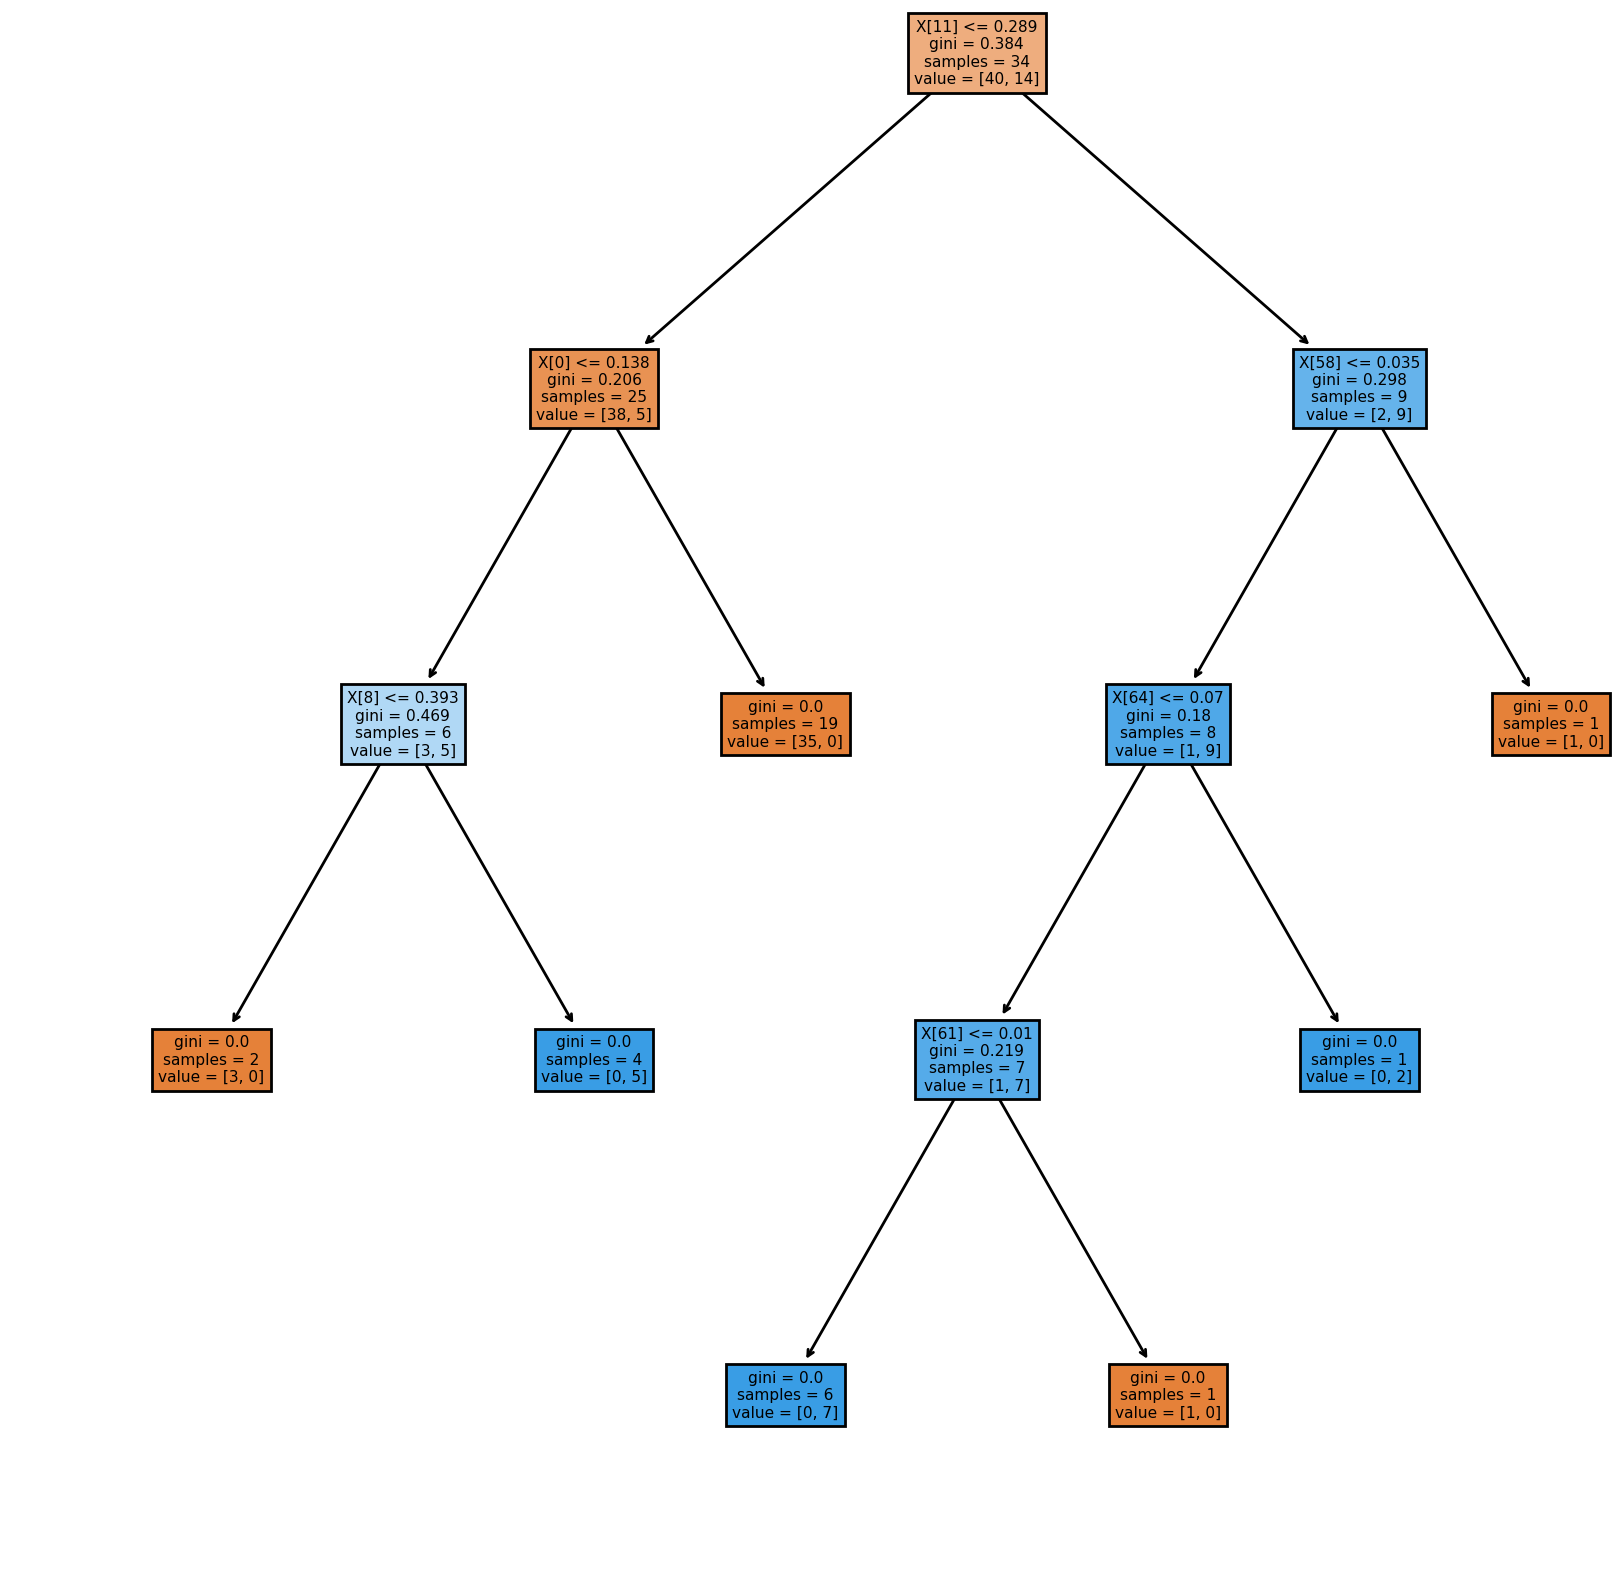

In [18]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], filled = True)